<a href="https://colab.research.google.com/github/chlolv/NLP_Project/blob/main/2_Paragraphs_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Package and definitions


In [1]:
import requests as req
import pandas as pd
import os
import re
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from termcolor import colored
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
try :
  import transformers
except :
  !pip install transformers
  import transformers
from transformers import AutoModel, BertTokenizerFast
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import AdamW
from sklearn.utils.class_weight import compute_class_weight
from nltk.tokenize import sent_tokenize
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from itertools import compress
import seaborn as sns
from tqdm import *
import time

# torch.cuda.is_available() returns a boolean to check if the GPU can be used or not
if torch.cuda.is_available():
  # if CUDA is available set 'cuda' as the device
  device = 'cuda'
  # and then print the name of the GPU
  print('DEVICE = ', colored(torch.cuda.get_device_name(0), "green" ) )
else:
  # else, set 'cpu' as device
  device = 'cpu'
  # just print than the CPU is used. Alternatively you can check your CPU with the following command (linux based) in the next cell:
  # ! lscpu
  print('DEVICE = ', colored('CPU', "blue"))

git_url = "https://raw.githubusercontent.com/chlolv/NLP_Project/main/Data/"
H_url = "H_series.csv"
book_url = "book_labels.csv"

# temp fixes due to csv use
H = req.get(git_url + H_url)
H = re.sub('\n\d{0,9}[0-9],',
           '\n', H.text[7:])
words = ["He-", "\\\\", '"', '"', "o-"]
H = re.sub("".join(words), "He-Who", H)
H = re.sub("\*", "" , H)
H = H.split('\n')

book = req.get(git_url + book_url)
book_label_list = re.sub('','0', book.text[6:])
book_label_list = re.sub('010','1', book_label_list)
book_label_list = re.sub('020','2', book_label_list)
book_label_list = re.sub('030','3', book_label_list)
book_label_list = re.sub('040','4', book_label_list)
book_label_list = re.sub('050','5', book_label_list)
book_label_list = re.sub('060','6', book_label_list)
book_label_list = re.sub('070','7', book_label_list)
book_label_list = book_label_list.split('\n')

book_label_list = [int(book) for book in book_label_list]


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
DEVICE =  Tesla T4


# Tache de classification des paragraphes

We want our algorithm to predict what characters are in each paragraph. 

In [2]:
# On se rammène à une tâche de classification
character_list = {1: ['Harry', 'Potter'], 2: ['Ron', 'Weasley'], 3: ['Hermione', 'Granger'], 4: ['Snape', 'Severus'], 
                  5:['Albus', 'Dumbledore'], 6: ['Dursley', 'Vernon', 'Dudley', 'Petunia'], 7: ['Draco', 'Malfoy']}
paragraph_character_labels = []
special_data = []
para_id = 0
for paragraph in tqdm_notebook(H) :
  paragraph_character_labels.append('')
  for key in character_list.keys() :
    character = character_list[key]
    if any(name in paragraph for name in character) :
      if paragraph_character_labels[para_id] != '' :
        paragraph_character_labels[para_id] += '_'
      paragraph_character_labels[para_id] += character[0]
  if paragraph_character_labels[para_id] == '' :
    paragraph_character_labels[para_id] += 'None'
  para_id += 1
pd.DataFrame.from_dict(Counter(paragraph_character_labels), orient = 'index').sort_values(by = [0], ascending = [False])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


  0%|          | 0/20931 [00:00<?, ?it/s]

,0
Harry,5214
None,3759
Harry_Ron,1758
Harry_Ron_Hermione,1438
Ron,1159
...,...
Ron_Albus_Draco,2
Ron_Hermione_Snape_Draco,2
Ron_Dursley_Draco,1
Harry_Ron_Hermione_Albus_Dursley,1


In [3]:
# On masque les noms propres 
for paragraph in tqdm_notebook(H) :
  tokenized = nltk.word_tokenize(paragraph)
  proper_nouns = [word for (word, pos) in nltk.pos_tag(tokenized) if pos in ['NNP', 'NNPS']] 
  for proper_noun in proper_nouns :
      paragraph = re.sub(proper_noun, 'charoffocus', paragraph)
      paragraph = re.sub('Dumbledore', 'charoffocus', paragraph)
      paragraph = re.sub('dumbledore', 'charoffocus', paragraph)
      paragraph = re.sub('charoffocus charoffocus', 'charoffocus', paragraph)
      paragraph = re.sub('charoffocus charoffocus', 'charoffocus', paragraph)
      paragraph = re.sub('charoffocus charoffocus', 'charoffocus', paragraph)
  special_data.append(paragraph)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/20931 [00:00<?, ?it/s]

In [4]:
textfile = open("special_data.txt", "w")
for element in special_data:
    textfile.write(element + "\n")
textfile.close()

In [5]:
# special_data = []
# with open('special_data.txt') as f:
#     special_data = f.readlines()

In [182]:
torch.cuda.empty_cache()

In [283]:
seed = 42
stratify_labels = []
labels = paragraph_character_labels
numeric_labels = pd.DataFrame(labels).replace(np.unique(labels), list(range(0, len(np.unique(labels)))))
numeric_labels = list(numeric_labels[0])
counted_data = pd.DataFrame.from_dict(Counter(paragraph_character_labels), orient = 'index').sort_values(by = [0], ascending = [False])
data_that_matters = counted_data.index[(counted_data[0] > 500) & (counted_data.index != 'None')]
for i in range(0, len(labels)) :
  if labels[i] in data_that_matters :
    new_label = labels[i] # + '_' + str(book_label_list[i])
  else :
    new_label = 'Other' # + '_' + str(book_label_list[i])
  stratify_labels.append(new_label)
counted_data = pd.DataFrame.from_dict(Counter(stratify_labels), orient = 'index').sort_values(by = [0], ascending = [False])
data_that_matters = counted_data.index[(counted_data[0] > 100)]
for i in range(0, len(labels)) :
  if stratify_labels[i] not in data_that_matters :
    stratify_labels[i] = 'Other' # + '_' + str(book_label_list[i])
  # if stratify_labels[i] == 'Other_0' : # temp fix for a '0' label due to csv use
  #   stratify_labels[i] = 'Other_1'     # temp fix for a '0' label due to csv use
numeric_stratify_labels = pd.DataFrame(stratify_labels).replace(np.unique(stratify_labels), list(range(1, len(np.unique(stratify_labels))+1)))
numeric_stratify_labels = list(numeric_stratify_labels[0])


In [284]:
from sklearn.utils import shuffle
new_data = []
new_labs = []
shuffled_data, shuffled_labels = shuffle(special_data, numeric_stratify_labels)

for label in np.unique(numeric_stratify_labels):
  j = 0
  i = 0
  for lab in shuffled_labels:
    if lab == label and j <= 500:
      new_data.append(shuffled_data[i])
      new_labs.append(shuffled_labels[i])
      j = j+1
    i = i+1
  
new_data, new_labs = shuffle(new_data, new_labs)

In [285]:
train_text, temp_text, train_labels, temp_labels = train_test_split(new_data, new_labs, 
                                                                    random_state=seed, 
                                                                    test_size=0.3) #formerly numeric_stratify_labels
BOOL = [label in numeric_labels for label in temp_labels]
temp_stratify_label = list(compress(stratify_labels, BOOL))
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
                                                                random_state=seed, 
                                                                test_size=0.5)

In [286]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')
# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [287]:
new_tokens = ['charoffocus']
num_added_toks = tokenizer.add_tokens(new_tokens)

In [288]:
max_seq_len = 100

tokens_train = tokenizer.batch_encode_plus(
    train_text,
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)


# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text,
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text,
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [289]:
torch.cuda.empty_cache()

In [290]:
# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels)
# for validation set
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels)
# for test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels)

In [291]:
#define a batch size
batch_size = 16 # formerly 32
# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)
# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)
# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)
# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)
# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

In [292]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

In [293]:
class BERT_Arch(nn.Module):
    def __init__(self, bert):
      super(BERT_Arch, self).__init__()
      self.bert = bert       
      # dropout layer
      self.dropout = nn.Dropout(0.1)      
      # relu activation function
      self.relu =  nn.ReLU()
      # dense layer 1
      self.fc1 = nn.Linear(768,512)
      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,len(np.unique(numeric_labels)))
      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)
    #define the forward pass
    def forward(self, sent_id, mask):
      #pass the inputs to the model  
      _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)
      x = self.fc1(cls_hs)
      x = self.relu(x)
      x = self.dropout(x)
      # output layer
      x = self.fc2(x)
      # apply softmax activation
      x = self.softmax(x)
      return x

In [294]:
bert.resize_token_embeddings(len(tokenizer))
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)
# push the model to GPU
#model = model.to(device)

In [295]:
# define the optimizer
optimizer = AdamW(model.parameters(), lr = 1e-3)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [296]:
#compute the class weights
class_wts = compute_class_weight('balanced', classes = np.unique(train_labels), y = train_labels)
# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)
# loss function
#cross_entropy  = nn.NLLLoss(weight=weights) (a priori pas besoin puisque on a stratifié)
cross_entropy  = nn.NLLLoss(reduction = 'mean')

In [297]:
torch.cuda.empty_cache()

In [298]:
# function to train the model
def train():
  model.train()
  total_loss, total_accuracy = 0, 0
  # empty list to save model predictions
  total_preds=[]
  # iterate over batches
  for step, batch in enumerate(train_dataloader):
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))
    # push the batch to gpu
    batch = [r.to(device) for r in batch]
    sent_id, mask, labels = batch
    # clear previously calculated gradients 
    model.zero_grad()        
    # get model predictions for the current batch
    preds = model(sent_id, mask)
    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)**2
    # add on to the total loss
    total_loss = total_loss + loss.item()
    # backward pass to calculate the gradients
    loss.backward()
    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    # update parameters
    optimizer.step()
    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()
    # append the model predictions
    total_preds.append(preds)
  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)
  #returns the loss and predictions
  return avg_loss, total_preds

In [299]:
# function for evaluating the model
def evaluate():
  print("\nEvaluating...")
  # deactivate dropout layers
  model.eval()
  total_loss, total_accuracy = 0, 0
  # empty list to save the model predictions
  total_preds = []
  # iterate over batches
  for step, batch in enumerate(val_dataloader):
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      # Calculate elapsed time in minutes.
#      elapsed = format_time(time.time() - t0)
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))
    # push the batch to gpu
    batch = [t.to(device) for t in batch]
    sent_id, mask, labels = batch
    # deactivate autograd
    with torch.no_grad():
      # model predictions
      preds = model(sent_id, mask)
      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)
      total_loss = total_loss + loss.item()
      preds = preds.detach().cpu().numpy()
      total_preds.append(preds)
  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)
  return avg_loss, total_preds

In [300]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
model = model.to(device)
# set initial loss to infinite
best_valid_loss = float('inf')
# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]
# number of training epochs
epochs = 2
#for each epoch
for epoch in range(epochs):
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    #train model
    train_loss, _ = train()
    #evaluate model
    valid_loss, _ = evaluate()
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 2
  Batch    50  of    220.
  Batch   100  of    220.
  Batch   150  of    220.
  Batch   200  of    220.

Evaluating...

Training Loss: 5.720
Validation Loss: 2.268

 Epoch 2 / 2
  Batch    50  of    220.
  Batch   100  of    220.
  Batch   150  of    220.
  Batch   200  of    220.

Evaluating...

Training Loss: 4.225
Validation Loss: 2.144


In [301]:
torch.cuda.empty_cache()

In [302]:
import pickle
filename = 'classif_model.sav'
pickle.dump(model, open(filename, 'wb'))


When the model has been trained and downloaded into colab envt, start here

In [303]:
import pickle
filename = 'classif_model.sav'
loaded_model = pickle.load(open(filename, 'rb'))

In [304]:
#load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [305]:
# get predictions for test data
with torch.no_grad():
  preds = model(test_seq.to(device), test_mask.to(device)) # formerly test_seq and test_maks with ".to(device)"
  preds = preds.detach().cpu().numpy()

In [306]:
# model's performance
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           1       0.29      0.47      0.36        66
           2       0.17      0.10      0.12        71
           3       0.24      0.58      0.34        71
           4       1.00      0.01      0.02        90
           5       0.13      0.34      0.19        65
           6       0.40      0.24      0.30        71
           7       0.23      0.32      0.27        79
           8       0.00      0.00      0.00        92
           9       0.00      0.00      0.00        76
          10       0.21      0.34      0.26        71

    accuracy                           0.22       752
   macro avg       0.27      0.24      0.19       752
weighted avg       0.28      0.22      0.18       752



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [307]:
# confusion matrix
pd.crosstab(test_y, preds)

col_0,1,2,3,4,5,6,7,10
row_0,,,,,,,,
1,31,3,14,0,2,1,11,4
2,9,7,14,0,22,2,13,4
3,16,2,41,0,10,0,0,2
4,6,7,16,1,28,4,9,19
5,1,4,21,0,22,5,3,9
6,2,1,14,0,25,17,2,10
7,8,2,15,0,11,1,25,17
8,23,6,23,0,15,3,12,10
9,9,7,8,0,18,2,19,13


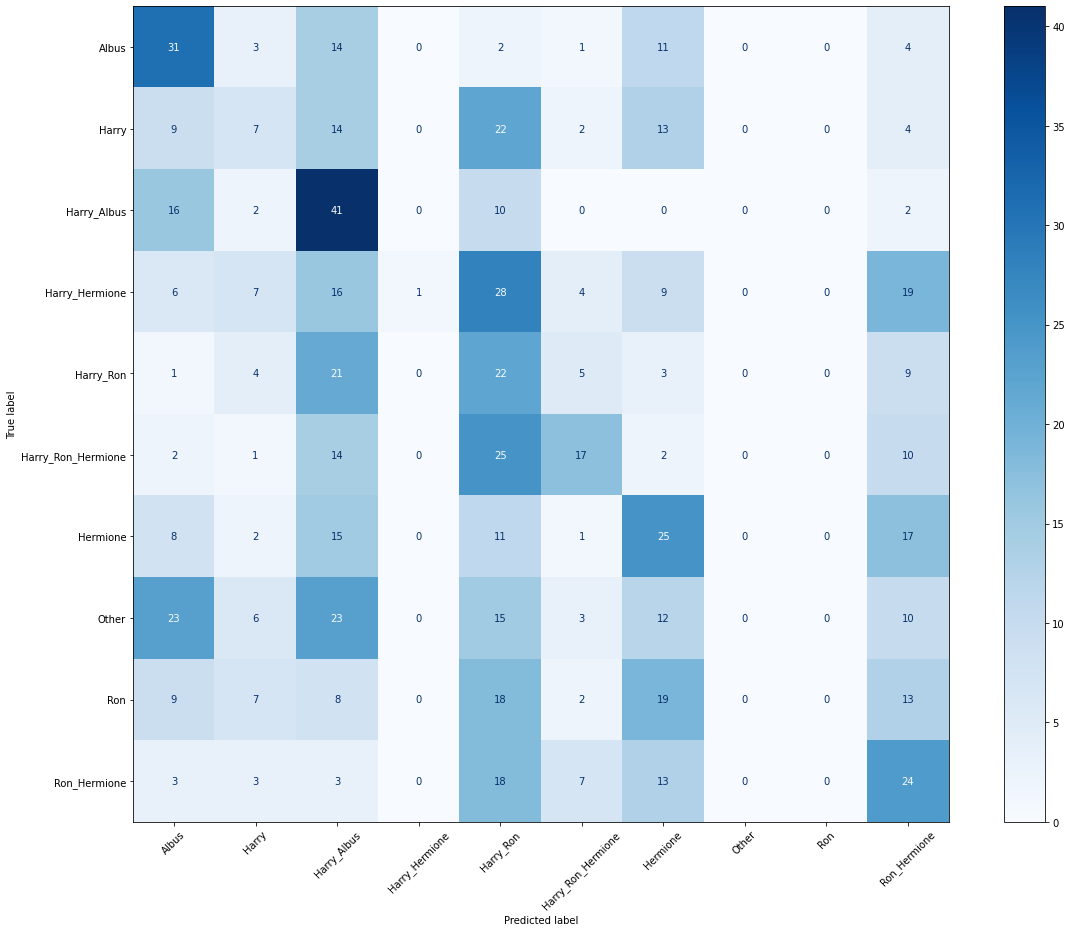

In [308]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# model's performance
plt.rcParams['figure.figsize'] = [20, 15]
cm = confusion_matrix(test_y, preds) 

cmd = ConfusionMatrixDisplay(cm, display_labels=np.unique(stratify_labels))
cmd.plot(cmap=plt.cm.Blues, xticks_rotation=45)